In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from scipy.fftpack import fft, rfft
import math
from tqdm import tqdm
from scipy.stats import moment
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import scipy.stats as st
from scipy.stats import randint as sp_randint
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()
path="C:/Users/danie/Documents/GitHub/OlgaDanCapstone/GPUProject"
os.chdir(path)

In [ ]:
# test_file = pd.read_csv('seg_00a37e.csv')
# print("Segment shape", test_file.shape)
# test_file.head()

In [2]:
%%time
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# test_file = pd.read_csv('seg_00a37e.csv')

Wall time: 1min 23s


In [ ]:
# pd.set_option("display.precision", 15)  # show more decimals
# train.head()

There are outliers in both directions; let's try to plot the same distribution with x in the range -20 to 30. The black line is the closest normal distribution (gaussian) possible.

## Part I: We will divide the train data set for segments

Group the training data in chunks of 150,000 examples and extract the following features:


In [3]:
from scipy.fftpack import fft, rfft
import math
from tqdm import tqdm
from scipy.stats import moment
rows = 6000000

#segments = int(np.floor(train.shape[0] / rows))
segments = 200000
X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(1,200000,1):
    seg = train.iloc[segment-1:segment, 0]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[segment-1:segment, 0]  # single value

    y_train.loc[segment, 'time_to_failure'] = np.sqrt(y)
    
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)

    X_train.loc[segment, '5<x<10'] = sum(x.between(5, 10))    
    X_train.loc[segment, '10<x<20'] = sum(x.between(10, 20))
    X_train.loc[segment, '20<x<30'] = sum(x.between(20, 30))
    X_train.loc[segment, '30<x<100'] = sum(x.between(30, 100))
    X_train.loc[segment, '100<x<500'] = sum(x.between(100, 500))
    X_train.loc[segment, '500<x<1000'] = sum(x.between(500, 1000))
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
        
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)

TypeError: 'int' object is not subscriptable

In [7]:
# X_train.shape
# y_train.shape

(150010, 1)

In [ ]:
#The Amplitude Spectral Density ASDs are the square root of the power spectral densities (PSDs), 
#which are averages of the square of the fast fourier transforms (FFTs) of the data.

# from scipy.fftpack import fft, rfft
# import math
# from tqdm import tqdm
# from scipy.stats import moment
# rows = 150_000
# segments = int(np.floor(train.shape[0] / rows))

# X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
# y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

# for segment in tqdm(range(segments)):
#     seg = train.iloc[segment*rows:segment*rows+rows]
#     #seg = seg[seg.acoustic_data.between(-20,30)]
#     x = seg['acoustic_data']   # pd series
#     y = seg['time_to_failure'].values[-1]  # single value
    
#     #y_train.loc[segment, 'time_to_failure'] = np.log(y)
#     y_train.loc[segment, 'time_to_failure'] = np.sqrt(y)
    
#     I_ave10 = 0.1*len(x)
#     II_ave10 = 0.2*len(x)
#     III_ave10 = 0.3*len(x)
#     IV_ave10 = 0.4*len(x)
#     V_ave10 = 0.5*len(x)
#     VI_ave10 = 0.6*len(x)
#     VII_ave10 = 0.7*len(x)
#     VIII_ave10 = 0.8*len(x)
#     IX_ave10 = 0.9*len(x)
    
    
#     X_train.loc[segment, 'rFFT mean'] = rfft(x).mean()
#     X_train.loc[segment, 'rFFT std'] = rfft(x).std()
       
#     X_train.loc[segment, '0<x<5'] = sum(x.between(0, 5))
#     X_train.loc[segment, '5<x<10'] = sum(x.between(5, 10))    
#     X_train.loc[segment, '10<x<20'] = sum(x.between(10, 20))
#     X_train.loc[segment, '20<x<30'] = sum(x.between(20, 30))
#     X_train.loc[segment, '30<x<100'] = sum(x.between(30, 100))
#     X_train.loc[segment, '100<x<500'] = sum(x.between(100, 500))
#     X_train.loc[segment, '500<x<1000'] = sum(x.between(500, 1000))
#     X_train.loc[segment, '1000<x<5000'] = sum(x.between(1000, 5000))
    
#     X_train.loc[segment, 'skewness'] = moment(x, moment=3)
#     X_train.loc[segment, 'kurtosis'] = moment(x, moment=4)
#     X_train.loc[segment, 'hypermoment'] = moment(x, moment=5)
#     X_train.loc[segment, 'hypermoment2'] = moment(x, moment=6)
#     X_train.loc[segment, 'ave'] = x.values.mean()
#     X_train.loc[segment, 'std'] = x.values.std()
#     X_train.loc[segment, 'max'] = x.values.max()
#     X_train.loc[segment, 'min'] = x.values.min()
        
#     X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
#     X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
#     X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
#     X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
#     X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
#     X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
#     X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
#     X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
#     X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
        
#      # New features - rolling features
#     for w in [100, 1000]:
#         x_roll_std = x.rolling(w).std().dropna().values
#         x_roll_mean = x.rolling(w).mean().dropna().values
#         x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
#         X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
#         X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
#         X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
#         X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
#         #X_train.loc[segment, 'mean_rFFT_roll_std_' + str(w)] = rfft(x_roll_std).mean()
#         #X_train.loc[segment, 'std_rFFT_roll_std_' + str(w)] = rfft(x_roll_std).std()
                        
#         X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
#         X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
#         X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
#         X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
#         #X_train.loc[segment, 'mean_rFFT_roll_mean_' + str(w)] = rfft(x_roll_mean).mean()
#         #X_train.loc[segment, 'std_rFFT_roll_mean_' + str(w)] = rfft(x_roll_mean).std()
               
              
#         X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
#         X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
#         X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
#         X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
#         X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
#         X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
#         X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
#         X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
#         X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
#         X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
#         X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
#         X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
#         X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
#         X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
#         X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
#         X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
#         X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)
       

In [8]:
X = X_train
Y = y_train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3,random_state=100, shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train)
scl_obj.fit(X_test)
X_test_scaled = scl_obj.transform(X_test)  
scl_obj.fit(X)
X_scaled = scl_obj.transform(X)

(105007, 49)
(45003, 49)
(105007, 1)
(45003, 1)


In [ ]:
# Load Data
# X = pd.read_csv('X.csv',index_col = 0)
# Y = pd.read_csv('Y.csv',index_col = 0)
# X_train = pd.read_csv('X_train.csv',index_col = 0)
# X_test = pd.read_csv('X_test.csv',index_col = 0)
# y_train = pd.read_csv('y_train.csv',index_col = 0)
# y_test = pd.read_csv('y_test.csv',index_col = 0)
# X_train_scaled = np.load('X_train_scaled.npy')
# X_test_scaled = np.load('X_test_scaled.npy')
# X_scaled = np.load('X_scaled.npy')

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [13]:
# https://scikit-learn.org/stable/modules/ensemble.html#forest
# The main parameters to adjust when using these methods is n_estimators and max_features.
#n_estimators is the number of trees in the forest. The larger the better, but also the longer it will take to compute.
#In addition, note that results will stop getting significantly better beyond a critical number of trees.
#max_features is the size of the random subsets of features to consider when splitting a node.
#The lower the greater the reduction of variance, but also the greater the increase in bias.
#Empirical good default values are max_features=n_features for regression problems, and
#max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data).
#Good results are often achieved when setting max_depth=None in combination with 
#min_samples_split=2 (i.e., when fully developing the trees). 
#Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM.
#The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are
#used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False).
#When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples.
#This can be enabled by setting oob_score=True.

grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50],
    'max_features': ['auto', 'sqrt', 'log2',10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100],
    'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100],
    'bootstrap': [True, False]
}
rfr = RandomForestRegressor(criterion='mse',n_estimators=300,n_jobs=-1)
gs1 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs1.fit(X_train_scaled, y_train.values.ravel())  
gs1.best_params_

{'min_samples_split': 24,
 'min_samples_leaf': 88,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': False}

In [10]:
# Save data
# X.to_csv(r'X.csv')
# Y.to_csv(r'Y.csv')
# X_train.to_csv(r'X_train.csv')
# X_test.to_csv(r'X_test.csv')
# y_train.to_csv(r'y_train.csv')
# y_test.to_csv(r'y_test.csv')
# np.save('X_train_scaled', X_train_scaled)
# np.save('X_test_scaled', X_test_scaled)
# np.save('X_scaled', X_scaled)

X.to_csv(r'Xbig.csv')
Y.to_csv(r'Ybig.csv')
X_train.to_csv(r'X_trainbig.csv')
X_test.to_csv(r'X_testbig.csv')
y_train.to_csv(r'y_trainbig.csv')
y_test.to_csv(r'y_testbig.csv')
np.save('X_train_scaledbig', X_train_scaled)
np.save('X_test_scaledbig', X_test_scaled)
np.save('X_scaledbig', X_scaled)

mean_absolute_error: 2.4784530157699027
r2_score: 0.21222217816390898


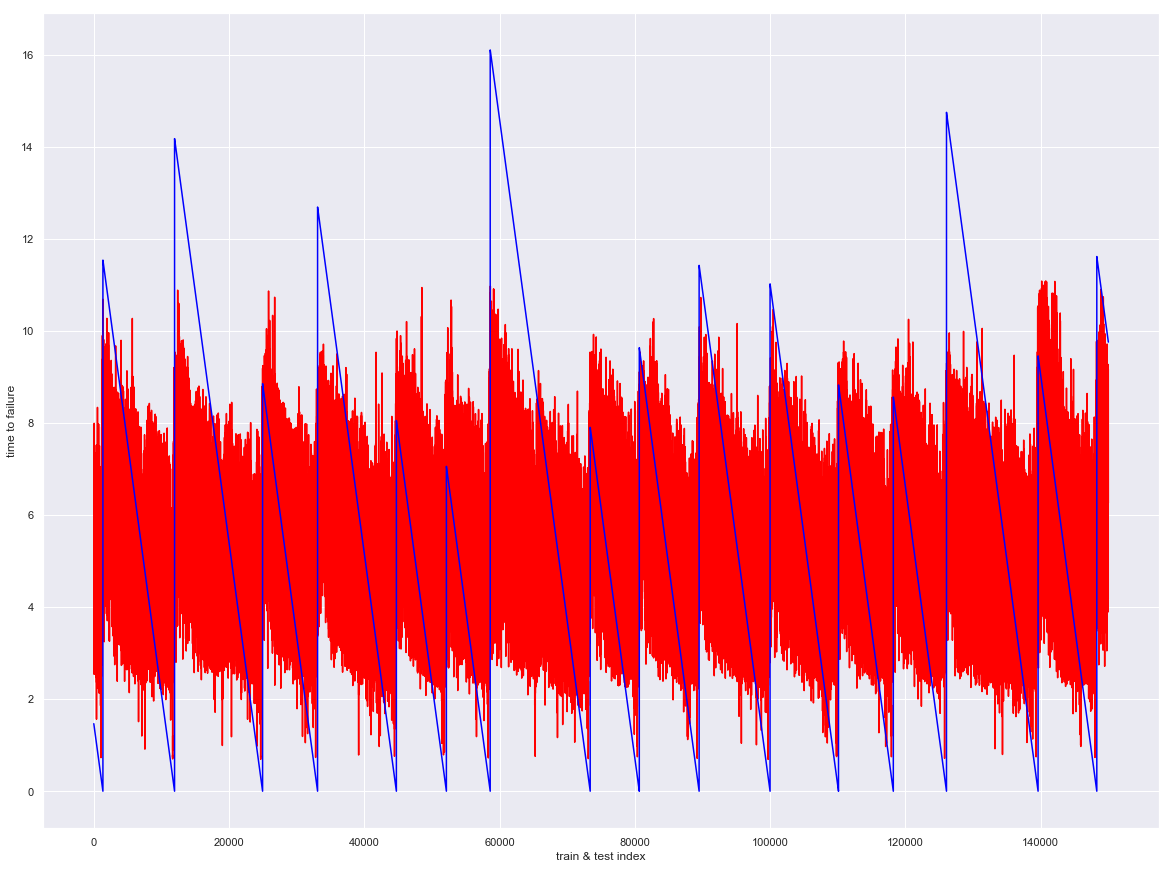

In [14]:
predictions =  gs1.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)

y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(figsize=(20,15))
ax3 = axis
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax3.plot(y_nolog_predict, color='red')
ax3.plot(y_nolog, color='blue')

In [ ]:

# 300 estimators
# mean_absolute_error: 2.0333497802169322
# r2_score: 0.49694656392058145

# 500 estimators
# mean_absolute_error: 2.033902275585301
# r2_score: 0.49555513299363063

# # 700 estimators
# mean_absolute_error: 2.0392882510864974
# r2_score: 0.49099361433577526

In [ ]:
# Load Model From Disk
full_predictions = pickle.load(open('full_predictions.sav', 'rb'))
predictions = pickle.load(open('predictions.sav', 'rb'))

In [ ]:
# Save Model to Disk
# filename = 'full_predictions.sav'
# pickle.dump(full_predictions, open(filename, 'wb'))
# filename = 'predictions.sav'
# pickle.dump(predictions, open(filename, 'wb'))
np.savetxt("y_nolog.csv", y_nolog, delimiter=",")
np.savetxt("y_nolog_predict.csv", y_nolog_predict, delimiter=",")

In [ ]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
rfr = DecisionTreeRegressor(criterion='mae')
gs3 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs3.fit(X_train_scaled, y_train.values.ravel())  
gs3.best_params_      

In [ ]:
predictions =  gs3.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs4 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs4.fit(X_train_scaled, y_train.values.ravel())  
gs4.best_params_      

In [ ]:
predictions =  gs4.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

The size of data is increasing day by day and it is becoming difficult for traditional data science algorithms to give faster results. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development. [https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc]

In [ ]:
import lightgbm as lgb

grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs5 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs5.fit(X_train_scaled, y_train.values.ravel())  
gs5.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

In [ ]:
predictions =  gs5.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': [6,11,15,20],
    'max_features': ['auto'],
    'min_samples_leaf': [10,16,20,40],
    'min_samples_split': [50,98,150,200],
    'n_estimators': [100, 200, 495,1000],
    'min_weight_fraction_leaf':  st.uniform(0, 0.5)
    }

etr = ExtraTreesRegressor(criterion='mae')
gs6 = RandomizedSearchCV(etr, param_distributions = grid)  
gs6.fit(X_train_scaled, y_train.values.ravel())  
gs6.best_params_ 

In [ ]:
predictions =  gs6.predict(X_test_scaled)
full_predictions = gs6.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
#The values of this array sum to 1, unless all trees are single node trees consisting of only the root node, 
#in which case it will be an array of zeros.
model = ExtraTreesRegressor(criterion='mse',max_depth=20,max_features='auto',min_samples_leaf=20,min_samples_split=50,
                            min_weight_fraction_leaf=0.2677238296443694,n_estimators=200 )
model.fit(X_train_scaled, y_train.values.ravel())

fold_importance_df = pd.DataFrame()
feature_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = X_train.columns
fold_importance_df["importance"] = model.feature_importances_[:len(X_train.columns)]
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('ExtraTreesRegressor Features')
plt.tight_layout()
plt.savefig('ExtraTreesRegressor_importances.png')

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                          'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8',
                          'principal component 9','principal component 10'])
principalDf.head()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
X_PCA_train_final = principalDf.values

In [ ]:
from sklearn.model_selection import train_test_split
X_PCA_train, X_PCA_test, y_train, y_test = train_test_split(X_PCA_train_final,Y,test_size=.3,random_state=100, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
    
scl_obj.fit(X_PCA_train)
X_PCA_train = scl_obj.transform(X_PCA_train)
scl_obj.fit(X_PCA_test)
X_PCA_test = scl_obj.transform(X_PCA_test)
scl_obj.fit(X_PCA_train_final)
X_PCA = scl_obj.transform(X_PCA_train_final)

In [ ]:
grid = {
    'max_depth': [8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': [2, 6, 12],
    #'n_estimators' : st.randint(10000, 20000),
}
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = RandomForestRegressor(criterion='mse',n_estimators=1000)
gs7 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs7.fit(X_PCA_train, y_train.values.ravel())  
gs7.best_params_   
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

In [ ]:
predictions =  gs7.predict(X_PCA_test)
full_predictions = gs7.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
import scipy.stats as st
from xgboost.sklearn import XGBRegressor

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    #"n_estimators": st.randint(10000, 20000),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1,n_estimators=500, cv=5)  
gs8 = RandomizedSearchCV(xgbreg, params)  
gs8.fit(X_PCA_train, y_train.values.ravel())  
gs8.best_params_

In [ ]:
predictions =  gs8.predict(X_PCA_test)
full_predictions = gs8.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
#The values of this array sum to 1, unless all trees are single node trees consisting of only the root node, 
#in which case it will be an array of zeros.
model = XGBRegressor(nthreads=-1,n_estimators=500,colsample_bytree=0.8385749300087559,gamma=4.711994964749211,
                     learning_rate=0.02198803862710416,max_depth=17,min_child_weight=114.35959341213693,
                     reg_alpha=59.19676051250868,subsample=0.9732956894126421)
model.fit(X_PCA_train, y_train)

fold_importance_df = pd.DataFrame()
feature_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = principalDf.columns
fold_importance_df["importance"] = model.feature_importances_[:len(principalDf.columns)]
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XGBRegressor Features')
plt.tight_layout()
plt.savefig('XGBRegressor_importances.png')

In [ ]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': st.randint(4,12),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': st.randint(2,12),
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
    
rfr = DecisionTreeRegressor(criterion='mae')
gs9 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs9.fit(X_PCA_train, y_train.values.ravel())  
gs9.best_params_ 

In [ ]:
predictions =  gs9.predict(X_PCA_test)
full_predictions = gs9.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs10 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs10.fit(X_PCA_train, y_train.values.ravel())  
gs10.best_params_ 

In [ ]:
predictions =  gs10.predict(X_PCA_test)
full_predictions = gs10.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
import lightgbm as lgb
import scipy.stats as st

grid = {
     'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs11 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs11.fit(X_PCA_train, y_train.values.ravel())  
gs11.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

In [ ]:
predictions =  gs11.predict(X_PCA_test)
full_predictions = gs11.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': [6,11,15,20],
    'max_features': ['auto'],
    'min_samples_leaf': [10,16,20,40],
    'min_samples_split': [50,98,150,200],
    'n_estimators': [100, 200, 495,1000],
    'min_weight_fraction_leaf':  st.uniform(0, 0.5)
    }

etr = ExtraTreesRegressor(criterion='mae')
gs12 = RandomizedSearchCV(etr, param_distributions = grid)  
gs12.fit(X_PCA_train, y_train.values.ravel())  
gs12.best_params_ 

In [ ]:
predictions =  gs12.predict(X_PCA_test)
full_predictions = gs12.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

In [ ]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

## Submission

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X.columns, dtype=np.float64, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data']  # pd series
            
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_test.loc[seg_id, 'rFFT mean'] = rfft(x).mean()
    X_test.loc[seg_id, 'rFFT std'] = rfft(x).std()
    
    X_test.loc[seg_id, '0<x<5'] = sum(x.between(0, 5))
    X_test.loc[seg_id, '5<x<10'] = sum(x.between(5, 10))    
    X_test.loc[seg_id, '10<x<20'] = sum(x.between(10, 20))
    X_test.loc[seg_id, '20<x<30'] = sum(x.between(20, 30))
    X_test.loc[seg_id, '30<x<100'] = sum(x.between(30, 100))
    X_test.loc[seg_id, '100<x<500'] = sum(x.between(100, 500))
    X_test.loc[seg_id, '500<x<1000'] = sum(x.between(500, 1000))
    X_test.loc[seg_id, '1000<x<5000'] = sum(x.between(1000, 5000))
    
    X_test.loc[seg_id, 'skewness'] = moment(x, moment=3)
    X_test.loc[seg_id, 'kurtosis'] = moment(x, moment=4)
    X_test.loc[seg_id, 'hypermoment'] = moment(x, moment=5)
    X_test.loc[seg_id, 'hypermoment2'] = moment(x, moment=6)
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
        
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [ ]:
X_test.head()

In [ ]:
X_test_scaled = scl_obj.fit_transform(X_test)

In [ ]:
predictions = gs6.predict(X_test_scaled)
submission['time_to_failure'] = np.square(predictions)
submission[submission < 0] = 0

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission_ExtraTreesRegressor.csv')